### Building models

Found coverage file with 10 samples and 20 unique taxa
Building 10 models...

----------------Parameters----------------
Diet/fecal compartments- TRUE
Coupling constraints- TRUE
Parallel- TRUE
Threads- 7
Solver- GUROBI
LP type- MPS
COBRA type- XML
compress- TRUE
Output directory- OUT/


100%|██████████| 10/10 [05:09<00:00, 30.98s/it]


-------------------------------------------------------
Finished building 10 models and associated LP problems!
Process took 5.204 minutes to run...


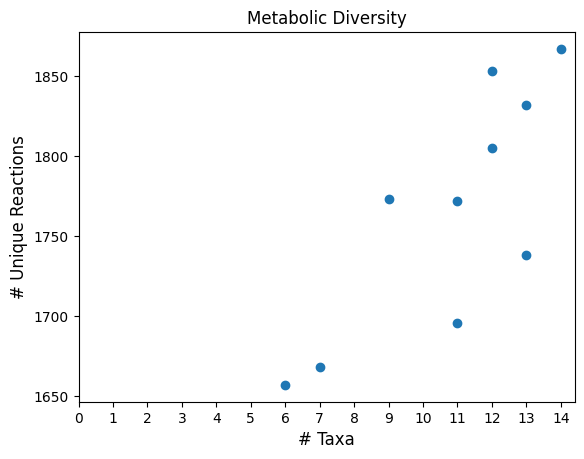

In [1]:
from pymgpipe import *

# If you want to generate a new random normCoverage file, run the following code-
#
# taxa = [x.split('.xml.gz')[0] for x in os.listdir('taxaModels')]
# df = pd.DataFrame(np.random.randint(0,1000,size=(20, 10)),columns=['sample_0'+str(i) for i in range(1,11)],index=taxa)
# rand_zero_one_mask = np.random.randint(2, size=df.shape)
# df = df.where(rand_zero_one_mask==0, 0).apply(lambda x: x/x.sum(),axis=0)
# df.to_csv('normCoverage.csv')

essential_metabs = ['EX_12dgr180(e)', 'EX_26dap_M(e)', 'EX_2dmmq8(e)', 'EX_2obut(e)', 'EX_3mop(e)', 'EX_4abz(e)', 'EX_4hbz(e)', 'EX_ac(e)', 'EX_acgam(e)', 'EX_acmana(e)', 'EX_acnam(e)', 'EX_ade(e)', 'EX_adn(e)', 'EX_adocbl(e)', 'EX_adpcbl(e)', 'EX_ala_D(e)', 'EX_ala_L(e)', 'EX_amet(e)', 'EX_amp(e)', 'EX_arab_D(e)', 'EX_arab_L(e)', 'EX_arg_L(e)', 'EX_asn_L(e)', 'EX_btn(e)', 'EX_ca2(e)', 'EX_cbl1(e)', 'EX_cgly(e)', 'EX_chor(e)', 'EX_chsterol(e)', 'EX_cit(e)', 'EX_cl(e)', 'EX_cobalt2(e)', 'EX_csn(e)', 'EX_cu2(e)', 'EX_cys_L(e)', 'EX_cytd(e)', 'EX_dad_2(e)', 'EX_dcyt(e)', 'EX_ddca(e)', 'EX_dgsn(e)', 'EX_fald(e)', 'EX_fe2(e)', 'EX_fe3(e)', 'EX_fol(e)', 'EX_for(e)', 'EX_gal(e)', 'EX_glc_D(e)', 'EX_gln_L(e)', 'EX_glu_L(e)', 'EX_gly(e)', 'EX_glyc(e)', 'EX_glyc3p(e)', 'EX_gsn(e)', 'EX_gthox(e)', 'EX_gthrd(e)', 'EX_gua(e)', 'EX_h(e)', 'EX_h2o(e)', 'EX_h2s(e)', 'EX_his_L(e)', 'EX_hxan(e)', 'EX_ile_L(e)', 'EX_k(e)', 'EX_lanost(e)', 'EX_leu_L(e)', 'EX_lys_L(e)', 'EX_malt(e)', 'EX_met_L(e)', 'EX_mg2(e)', 'EX_mn2(e)', 'EX_mqn7(e)', 'EX_mqn8(e)', 'EX_nac(e)', 'EX_ncam(e)', 'EX_nmn(e)', 'EX_no2(e)', 'EX_ocdca(e)', 'EX_ocdcea(e)', 'EX_orn(e)', 'EX_phe_L(e)', 'EX_pheme(e)', 'EX_pi(e)', 'EX_pnto_R(e)', 'EX_pro_L(e)', 'EX_ptrc(e)', 'EX_pydx(e)', 'EX_pydxn(e)', 'EX_q8(e)', 'EX_rib_D(e)', 'EX_ribflv(e)', 'EX_ser_L(e)', 'EX_sheme(e)', 'EX_so4(e)', 'EX_spmd(e)', 'EX_thm(e)', 'EX_thr_L(e)', 'EX_thymd(e)', 'EX_trp_L(e)', 'EX_ttdca(e)', 'EX_tyr_L(e)', 'EX_ura(e)', 'EX_val_L(e)', 'EX_xan(e)', 'EX_xyl_D(e)', 'EX_zn2(e)', 'EX_glu_D(e)', 'EX_melib(e)', 'EX_chtbs(e)', 'EX_metsox_S_L(e)', 'EX_hdca(e)', 'EX_gam(e)', 'EX_indole(e)', 'EX_glcn(e)', 'EX_coa(e)', 'EX_man(e)', 'EX_fum(e)', 'EX_succ(e)', 'EX_no3(e)', 'EX_ins(e)', 'EX_uri(e)', 'EX_drib(e)', 'EX_pime(e)', 'EX_lac_L(e)', 'EX_glypro(e)', 'EX_urea(e)', 'EX_duri(e)', 'EX_h2(e)', 'EX_mal_L(e)', 'EX_tre(e)', 'EX_orot(e)', 'EX_glymet(e)', 'EX_glyleu(e)', 'EX_sucr(e)', 'EX_sbt_D(e)', 'EX_akg(e)', 'EX_glytyr(e)', 'EX_glypro(e)', 'EX_glyphe(e)', 'EX_glymet(e)', 'EX_glyleu(e)', 'EX_glyglu(e)', 'EX_glygln(e)', 'EX_glyasp(e)', 'EX_glyasn(e)', 'EX_alagly(e)', 'EX_gam(e)', 'EX_mantr(e)']

# # STEP 1- BUILD MODELS
build_models(
    coverage_file='abundances.csv',
    taxa_dir='taxaModels',
    out_dir='out',
    essential_metabolites=essential_metabs,
    diet_fecal_compartments=True,
    coupling_constraints=True,
    remove_reverse_vars_from_lp=True,
    hard_remove=True,
    compress=True,
    threads=-1,
    parallel=True,
    solver='gurobi',
    cobra_type='.xml',
    lp_type='.mps',
    diet='AverageEuropeanDiet', #'personalized_diet.csv',
    compute_metrics=True
)

In [ ]:
from pymgpipe import *

# STEP 2- COMPUTE NMPCS
compute_nmpcs(
    samples='out/problems/',
    out_dir='out/',
    threshold=0,
    fva_type=FVA_TYPE.REGULAR,
    force=True,
    threads=-1,
    objective_percent=99.99
)

### Loading models

In [ ]:
from pymgpipe import *

# Loading a cobra model
cobra_model = load_cobra_model('out/models/mc1.xml.gz')
print(type(cobra_model))

# Loading an optlang model
optlang_model = load_model('out/problems/mc1.mps.7z',solver='gurobi') 
print(type(optlang_model))
# OR 
optlang_model = load_model('out/models/mc1.xml.gz')
print(type(optlang_model))

### Solving models

In [ ]:
from pymgpipe import solve_model, load_model

sol = solve_model(model='out/problems/mc1.mps.7z',solver='gurobi')

# OR 

m = load_model('out/problems/mc1.mps.7z', solver='gurobi')
target_reactions = get_reactions(m,regex='Diet_EX_.*')
sol = solve_model(model=m,reactions=target_reactions)

# OR 

sol = solve_model(model='out/models/mc1.xml.gz',solver='gurobi')

### Computin NMPCs

In [ ]:
from pymgpipe import compute_nmpcs

r = compute_nmpcs(samples='out/problems/',fva_type='regular', write_to_file=False,diet_fecal_compartments=True,force=True, threads=-1)
r.nmpc

### Adding Diets

In [ ]:
from pymgpipe import *

model = load_model('out/problems/mc1.mps.gz')
add_diet_to_model(model,'HighFatLowCarbDiet')
compute_nmpcs(samples=model,write_to_file=False).nmpc